In [12]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

all_data = []
for ncpu in [1, ]:
    df = pd.read_csv(f'notes/data/rtx4060/{ncpu}cpu.csv')
    df['gpu_type'] = 'rtx4060'
    df['ncpu'] = ncpu
    all_data.append(df)


for ncpu in [1, 2, 4, 8, 16, 32]:
    df = pd.read_csv(f'notes/data/v100/{ncpu}cpu.csv')
    df['gpu_type'] = 'v100'
    df['ncpu'] = ncpu
    all_data.append(df)

for ncpu in [1, 2, 4, 8, 16, 32]:
    df = pd.read_csv(f'notes/data/rtx4090/{ncpu}cpu.csv')
    df['gpu_type'] = 'rtx4090'
    df['ncpu'] = ncpu
    all_data.append(df)

for ncpu in [1, 2, 4, 8, 16, 32]:
    df = pd.read_csv(f'notes/data/a100/{ncpu}cpu.csv')
    df['gpu_type'] = 'a100'
    df['ncpu'] = ncpu
    all_data.append(df)

for ncpu in [1, 2, 4, 8, 16, 32]:
    df = pd.read_csv(f'notes/data/h100/{ncpu}cpu.csv')
    df['gpu_type'] = 'h100'
    df['ncpu'] = ncpu
    all_data.append(df)

for ncpu in [1, 2, 4, 8, 16, 32]:
    df = pd.read_csv(f'notes/data/h200/{ncpu}cpu.csv')
    df['gpu_type'] = 'h200'
    df['ncpu'] = ncpu
    all_data.append(df)

all_data = pd.concat(all_data, ignore_index=True)
is_alkane = all_data['structure'].str.contains('alkane')
all_data['is_alkane'] = is_alkane
alkanes = all_data[all_data['is_alkane']]
df = all_data[~all_data['is_alkane']]
df

,structure,nat,nprim,maxl,max_nnl,mean_nnl,max_nsh,cpu_time,gpu_gb_in,gpu_gb_out,gpu_gb_total,gpu_between_atoms,gpu_in_atoms,gpu_time,gpu_walltime,gpu_type,ncpu,is_alkane
0,H2,2,6,0,1,0,1,0.052038,0.000001,0.000000,0.000002,6.083584,0.385216,6.468800,1513.157415,rtx4060,1,False
2,dna,387,6,2,164,69,3,463.302876,0.232067,0.231803,0.463871,268.163086,7.191552,275.354645,376.435950,rtx4060,1,False
4,1lyz-lysozyme,1102,6,2,310,99,3,1127.856173,1.749900,1.748891,3.498791,837.918579,13.484032,851.402588,1601.334776,rtx4060,1,False
5,103l-hydrolase,1404,6,2,313,99,3,1690.300022,2.816439,2.815150,5.631588,1048.050537,16.222208,1064.272705,2307.191267,rtx4060,1,False
10,H2,2,6,0,1,0,1,0.060359,0.000001,0.000000,0.000002,11.777024,2.130944,13.907969,190.291800,v100,1,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
317,SiH4,5,6,2,4,2,3,3.913862,0.000018,0.000015,0.000033,0.286432,0.563328,0.849760,1.818231,h200,32,False
318,GLU,29,6,1,28,14,2,4.165596,0.000453,0.000444,0.000896,0.447136,0.252352,0.699488,2.291105,h200,32,False
320,dna,387,6,2,165,69,3,44.968294,0.232068,0.231803,0.463871,6.025408,0.741152,6.766560,169.510987,h200,32,False
322,1lyz-lysozyme,1102,6,2,311,99,3,341.458180,1.749900,1.748891,3.498791,17.721632,0.964128,18.685760,1189.516809,h200,32,False


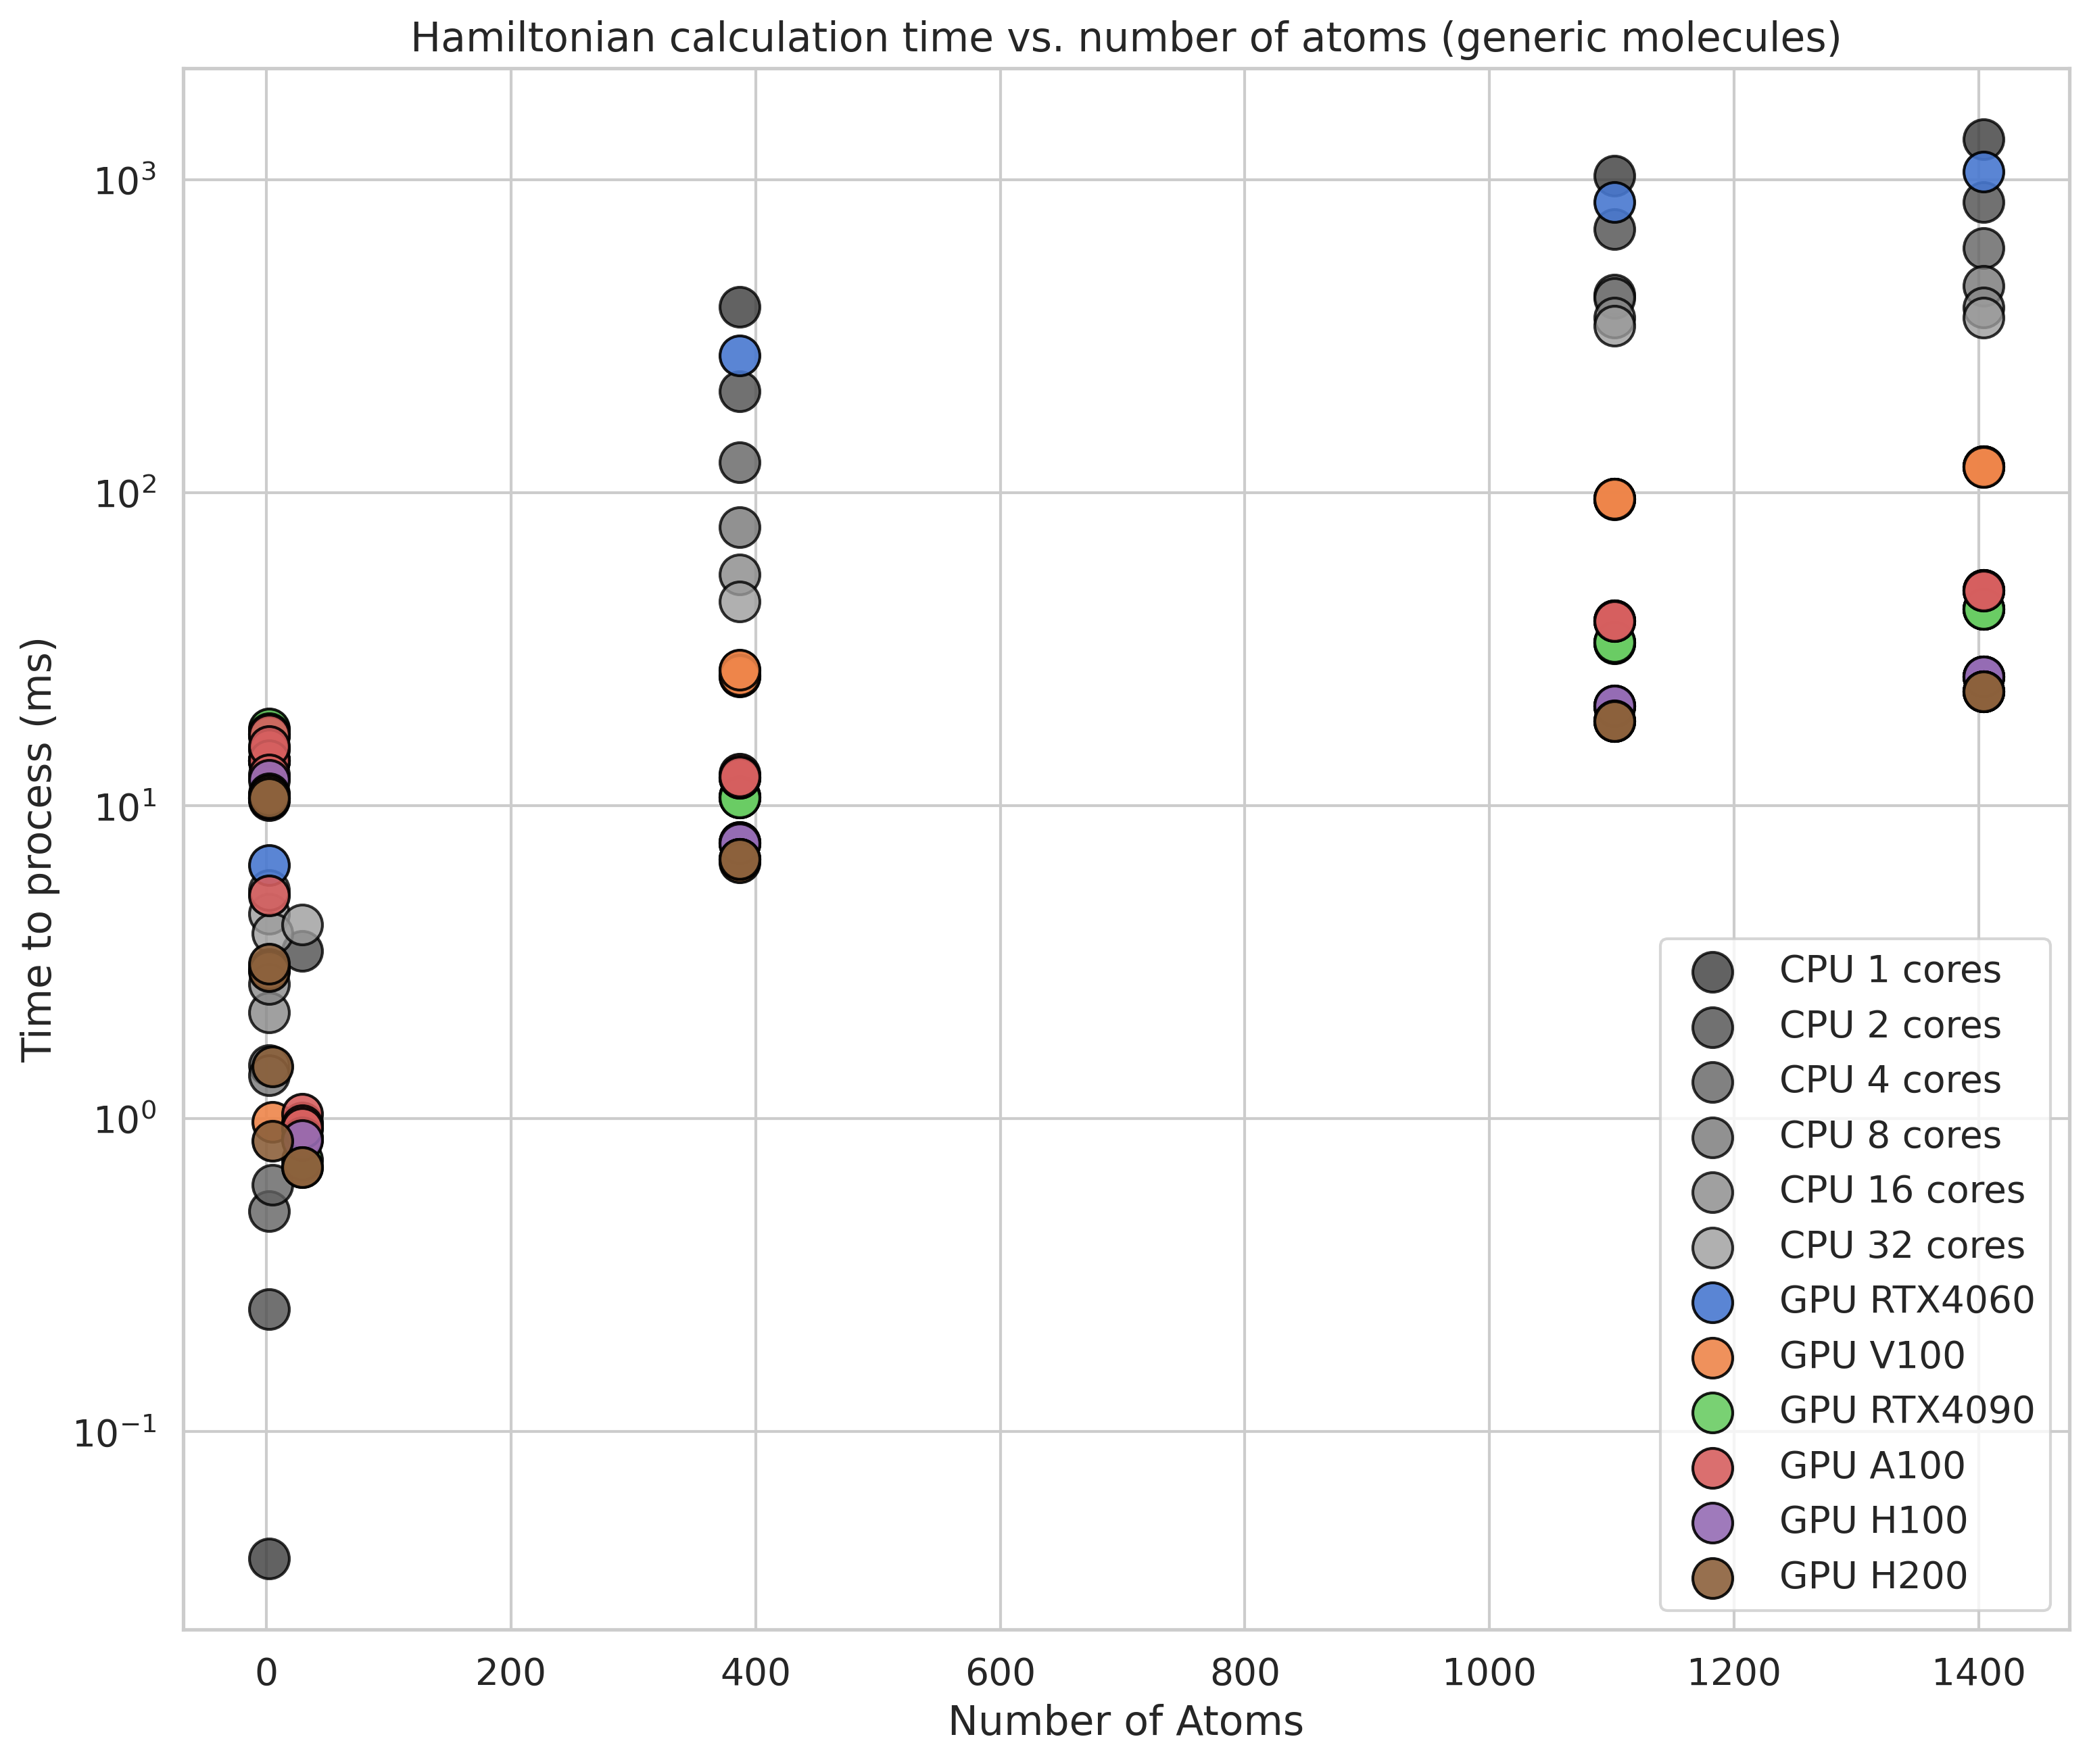

In [13]:
# First plot, plot 1/cpu_time and 1/gpu_time, over increasing number of atoms `nat` (x-axis).
# Lines: gray to black CPU, 1, 2, ... 32
# Lines: nvidia green, GPUs, rtx4060, rtx4090, h100
plt.figure(figsize=(12, 10), dpi=300)
sns.set_style("whitegrid")
sns.set_palette("dark")
sns.set_context("notebook", font_scale=1.2)

# Plot CPU data
df = df.sort_values(by='nat')
natoms = df['nat']
cpu_times = df['cpu_time']
cpu_cores = df['ncpu']
gpu_times = df['gpu_time']
gpu_types = df['gpu_type']

cpu_palette = sns.color_palette("gray", n_colors=12)  # 6 shades of gray for 1, 2, 4, 8, 16, 32 cores
for i, ncpu in enumerate([1, 2, 4, 8, 16, 32]):
  mask = (cpu_cores == ncpu) & (gpu_types == 'h200')
  plt.scatter(natoms[mask], cpu_times[mask], 
           label=f'CPU {ncpu} cores', 
           color=cpu_palette[i + 2], alpha=0.8, marker='o', s=200, edgecolor='black')

# gpu_palette = sns.color_palette("Greens", n_colors=6)  # 3 shades of green for rtx4060, rtx4090, h100
gpu_palette = sns.color_palette("muted", n_colors=12)  # Viridis palette for GPUs
for i, gpu_type in enumerate(['rtx4060', 'v100', 'rtx4090', 'a100', 'h100', 'h200']):
  mask = (gpu_types == gpu_type)
  color = gpu_palette[i]
  plt.scatter(natoms[mask], gpu_times[mask], label=f'GPU {gpu_type.upper()}', color=color, alpha=0.9, marker='o', s=200, edgecolor='black')

plt.xlabel('Number of Atoms')
plt.ylabel('Time to process (ms)')
plt.yscale('log')
plt.title('Hamiltonian calculation time vs. number of atoms (generic molecules)')
plt.legend()

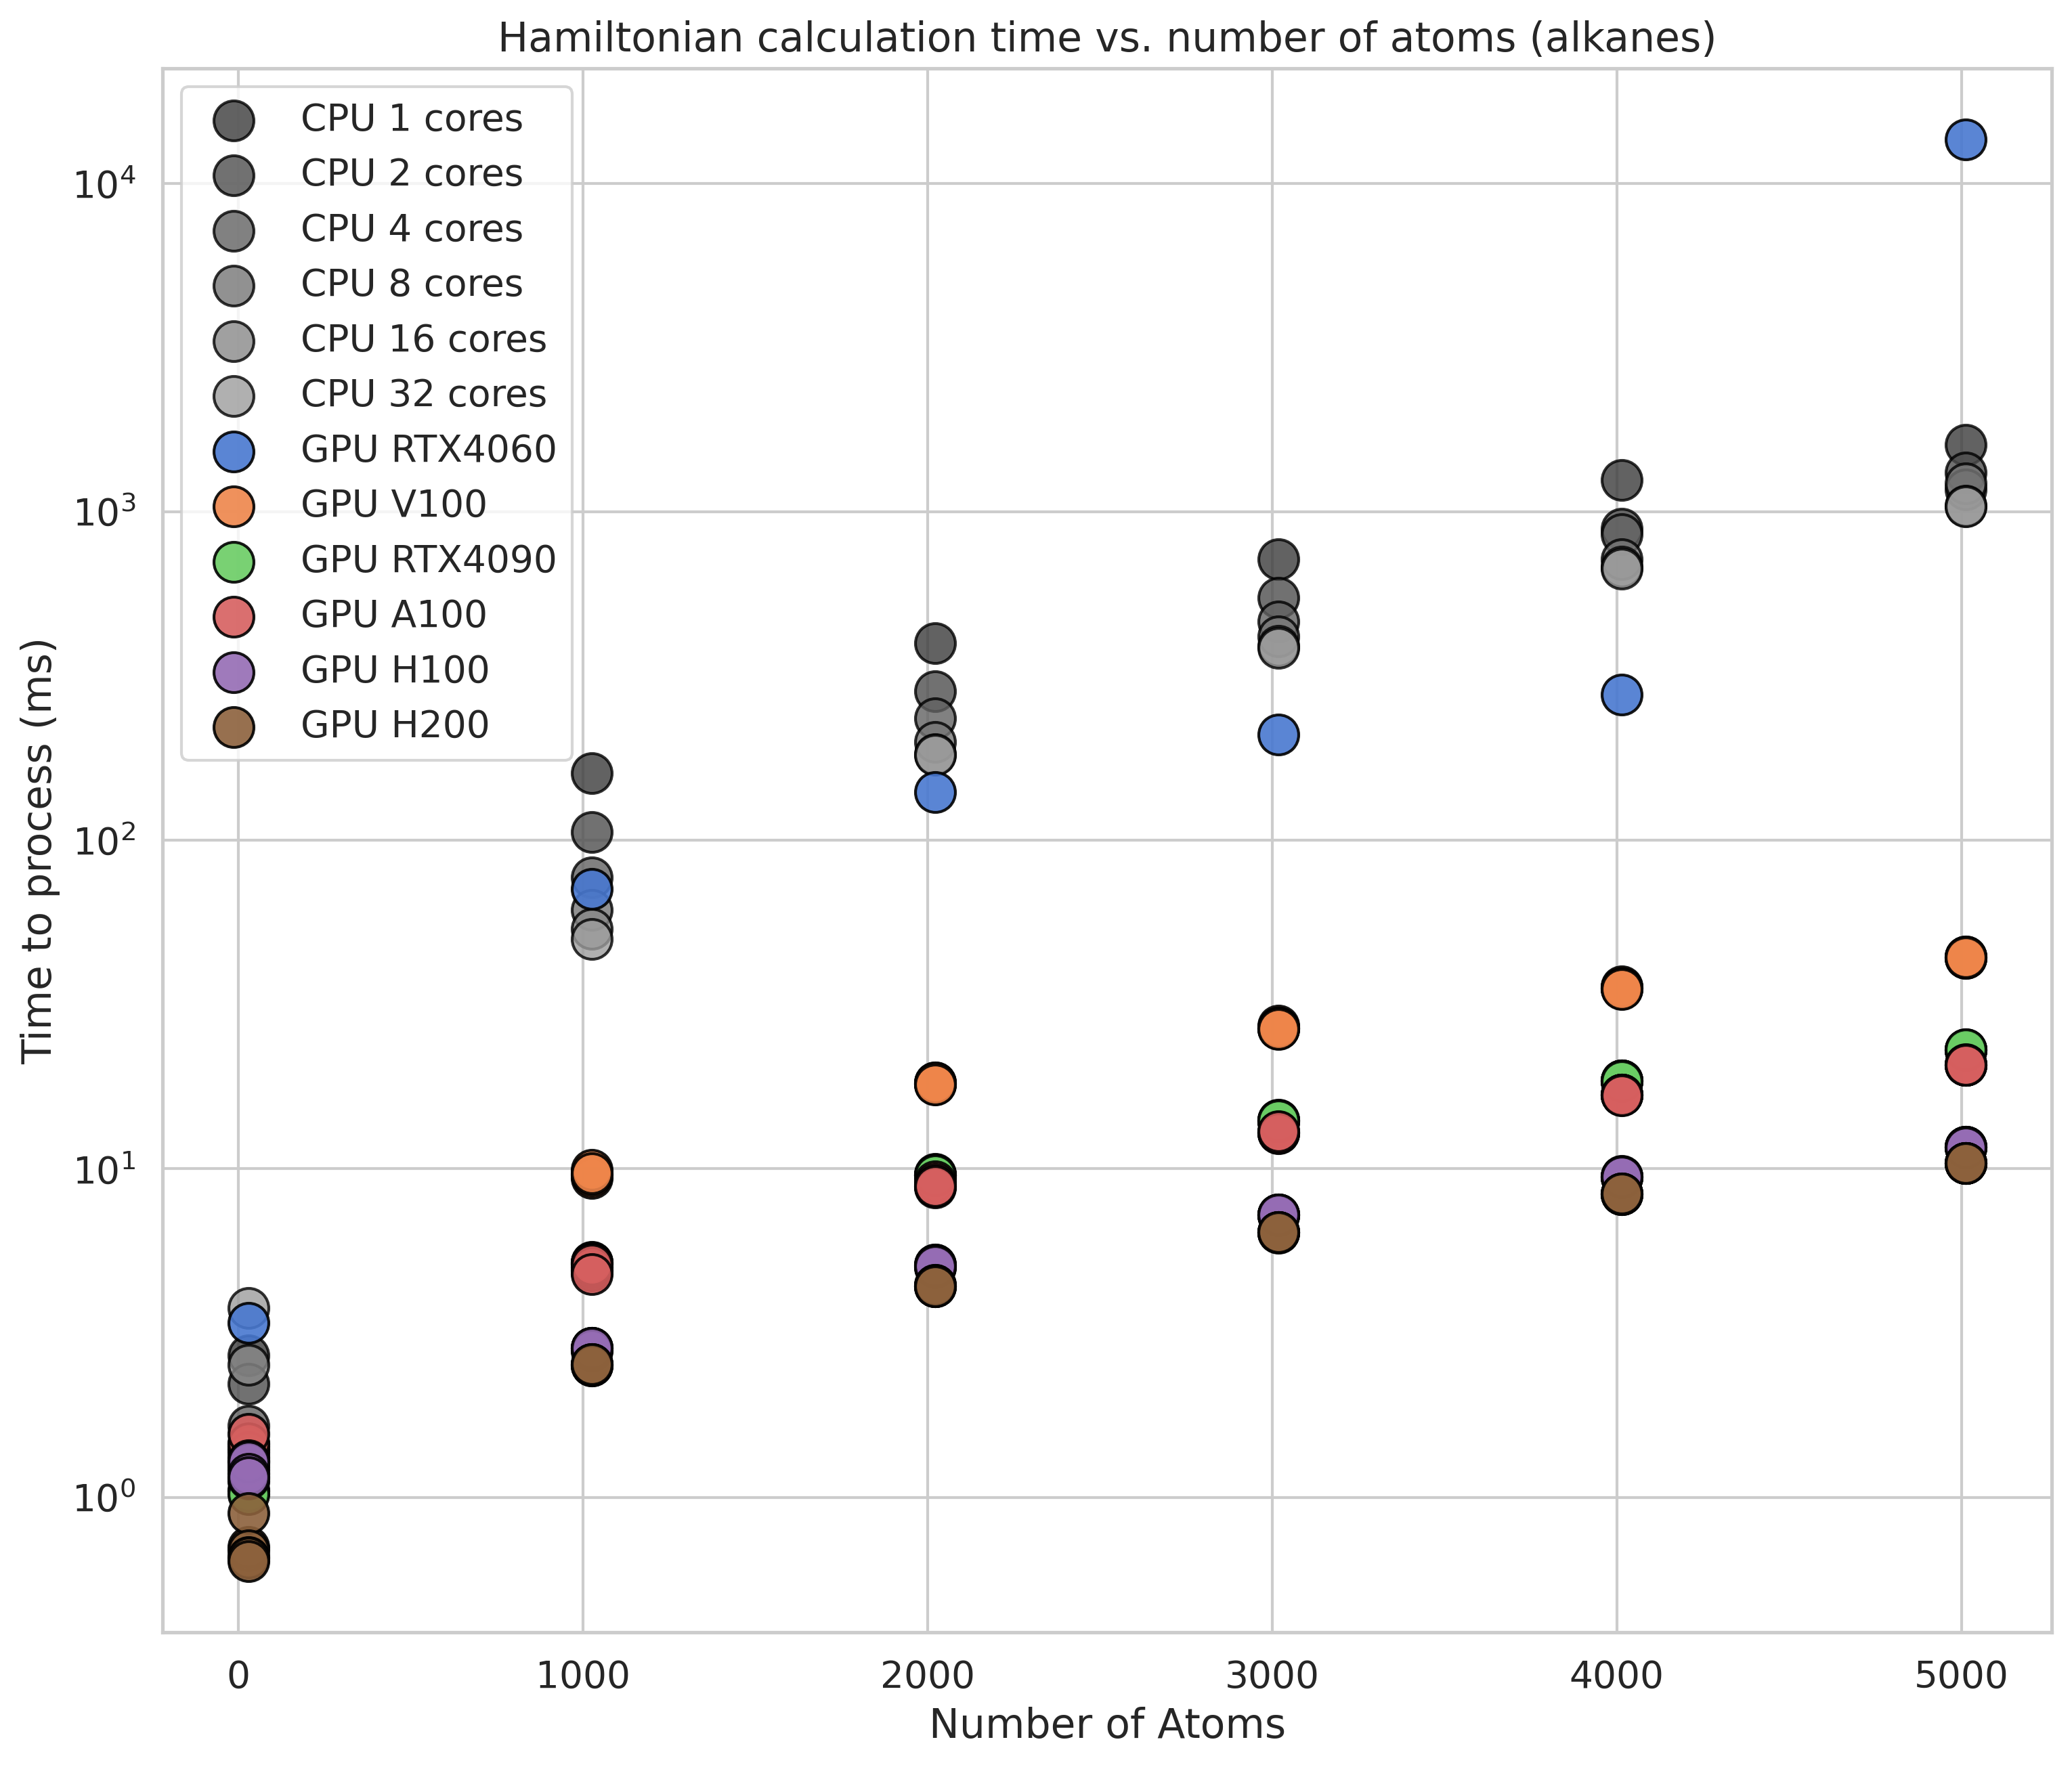

In [15]:
# First plot, plot 1/cpu_time and 1/gpu_time, over increasing number of atoms `nat` (x-axis).
# Lines: gray to black CPU, 1, 2, ... 32
# Lines: nvidia green, GPUs, rtx4060, rtx4090, h100
plt.figure(figsize=(12, 10), dpi=300)
sns.set_style("whitegrid")
sns.set_palette("dark")
sns.set_context("notebook", font_scale=1.2)

# Plot CPU data
df = alkanes.sort_values(by='nat')
natoms = df['nat']
cpu_times = df['cpu_time']
cpu_cores = df['ncpu']
gpu_times = df['gpu_time']
gpu_types = df['gpu_type']

cpu_palette = sns.color_palette("gray", n_colors=12)  # 6 shades of gray for 1, 2, 4, 8, 16, 32 cores
for i, ncpu in enumerate([1, 2, 4, 8, 16, 32]):
  mask = (cpu_cores == ncpu) & (gpu_types == 'h200')
  plt.scatter(natoms[mask], cpu_times[mask], 
           label=f'CPU {ncpu} cores', 
           color=cpu_palette[i + 2], alpha=0.8, marker='o', s=200, edgecolor='black')

# gpu_palette = sns.color_palette("Greens", n_colors=6)  # 3 shades of green for rtx4060, rtx4090, h100
gpu_palette = sns.color_palette("muted", n_colors=12)  # Viridis palette for GPUs
for i, gpu_type in enumerate(['rtx4060', 'v100', 'rtx4090', 'a100', 'h100', 'h200']):
  mask = (gpu_types == gpu_type)
  color = gpu_palette[i]
  plt.scatter(natoms[mask], gpu_times[mask], label=f'GPU {gpu_type.upper()}', color=color, alpha=0.9, marker='o', s=200, edgecolor='black')

plt.xlabel('Number of Atoms')
plt.ylabel('Time to process (ms)')
plt.yscale('log')
plt.title('Hamiltonian calculation time vs. number of atoms (alkanes)')
plt.legend()

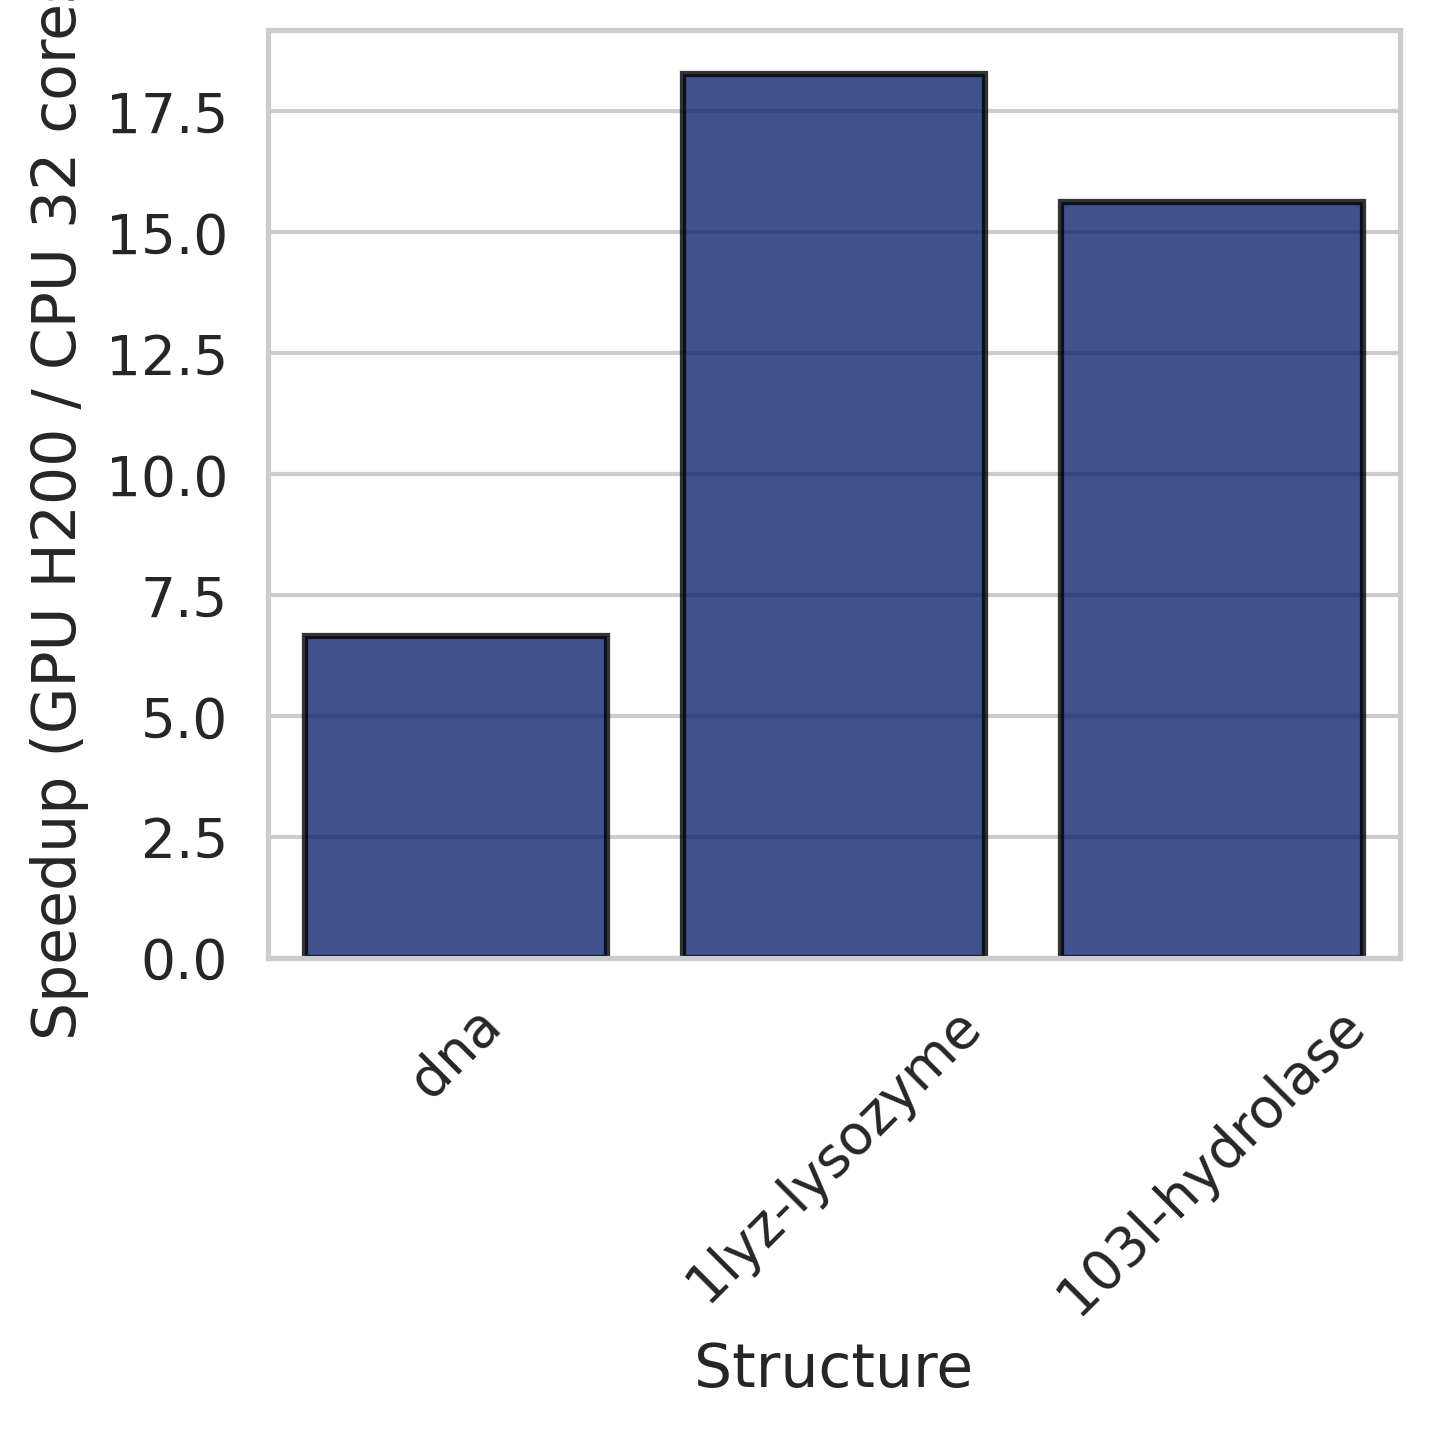

In [16]:
# Bar chart of speedup, H200, vs 32 CPUs, on dna
df = all_data[(all_data['gpu_type'] == 'h200') & (all_data['ncpu'] == 32) & (all_data['is_alkane'] == False) & (all_data['nat'] > 100)]

cpu_times = df['cpu_time']
gpu_times = df['gpu_time']

# Calculate speedup
speedup = cpu_times / gpu_times

# speedup values
# sns.barplot(penguins, x="island", y="body_mass_g", hue="sex")
plt.figure(figsize=(5, 5), dpi=300)
sns.barplot(
  x=df['structure'],
  y=speedup,
  edgecolor='black',
  linewidth=1.5,
  alpha=0.8,
)

plt.xlabel('Structure')
plt.ylabel('Speedup (GPU H200 / CPU 32 cores)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('notes/figures/speedup_h200_vs_32cpu.png', dpi=300)
plt.show()

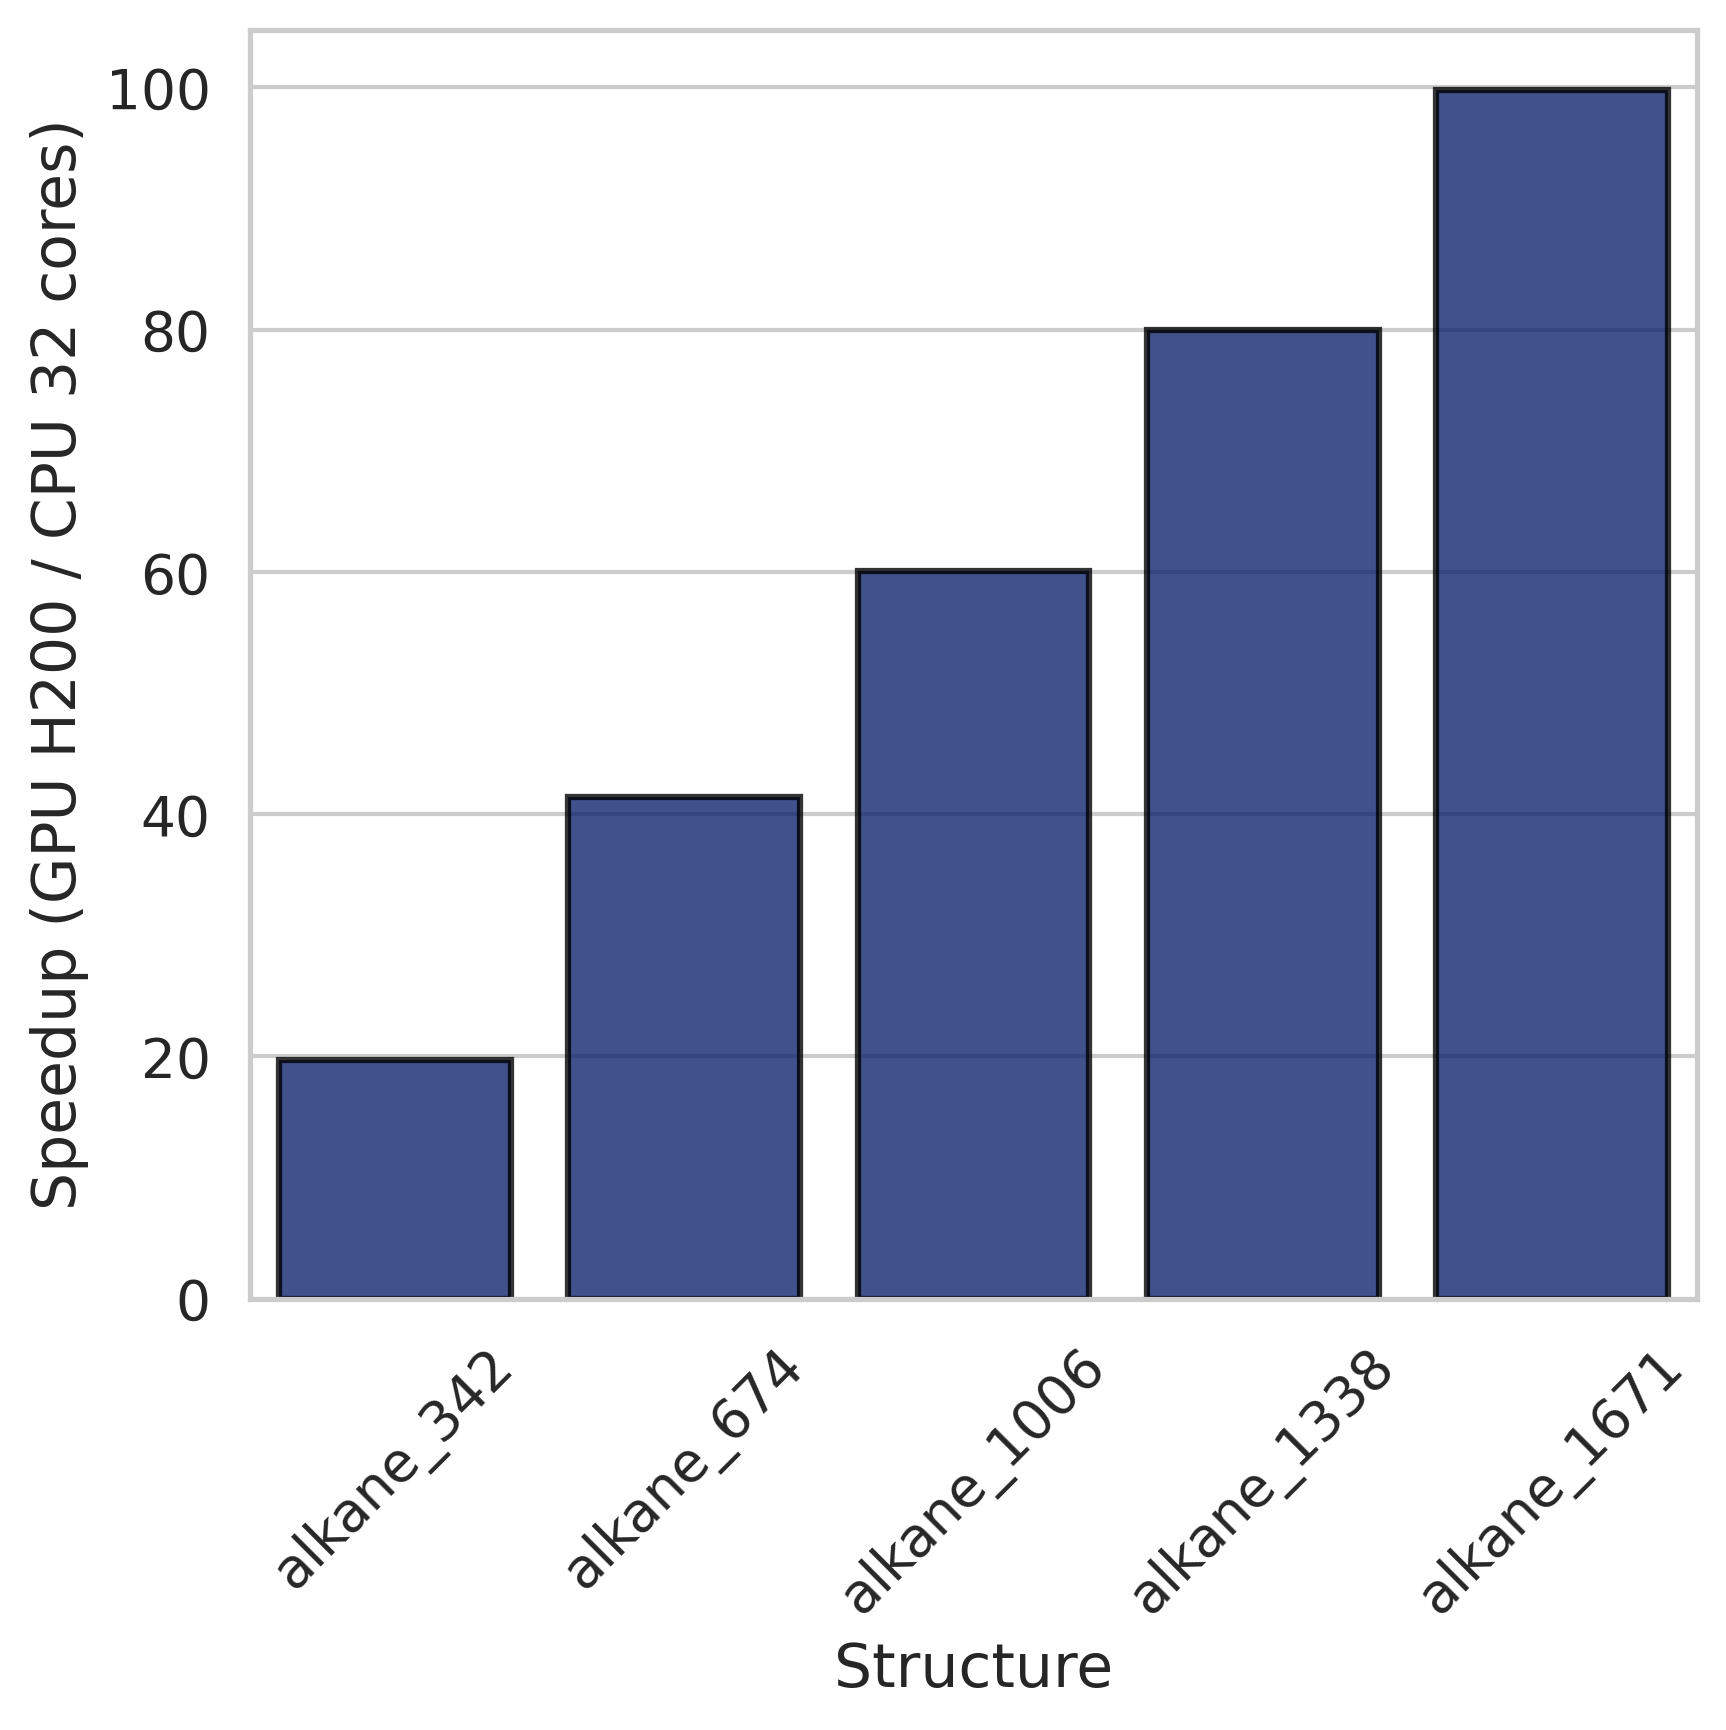

In [17]:
# Bar chart of speedup, H200, vs 32 CPUs, on dna
df = all_data[(all_data['gpu_type'] == 'h200') & (all_data['ncpu'] == 32) & (all_data['is_alkane'] == True) & (all_data['nat'] > 100)]

cpu_times = df['cpu_time']
gpu_times = df['gpu_time']

# Calculate speedup
speedup = cpu_times / gpu_times

# speedup values
# sns.barplot(penguins, x="island", y="body_mass_g", hue="sex")
plt.figure(figsize=(6, 6), dpi=300)
sns.barplot(
  x=df['structure'],
  y=speedup,
  edgecolor='black',
  linewidth=1.5,
  alpha=0.8,
)

plt.xlabel('Structure')
plt.ylabel('Speedup (GPU H200 / CPU 32 cores)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('notes/figures/alkane_speedup.png', dpi=300)
plt.show()

In [65]:
all_data.structure.unique()

array(['H2', 'alkane_10', 'dna', 'alkane_342', '1lyz-lysozyme',
       '103l-hydrolase', 'alkane_674', 'alkane_1006', 'alkane_1338',
       'alkane_1671', 'GLU', 'SiH4', 'LiH', 'S2'], dtype=object)

In [55]:
!meson compile -C build/ && ./build/app/tblite test/perf/aspirin.sdf

INFO: autodetecting backend as ninja
INFO: calculating backend command to run: /usr/bin/ninja -C /home/tornikeo/Documents/personal/thesis/qcxms/subprojects/tblite/build
ninja: Entering directory `/home/tornikeo/Documents/personal/thesis/qcxms/subprojects/tblite/build'
ninja: no work to do.
xTB calculator
 | screened Coulomb repulsion
 | Coulomb electrostatics
 |  * isotropic Klopman-Ohno electrostatics
 |  * anisotropic electrostatics
 |  * onsite third-order electrostatics
 | self-consistent DFT-D4 dispersion

 repulsion energy        4.5921005160310E-01 Eh
 dispersion energy       9.2864624768801E-05 Eh
 number of electrons     6.8000000000000E+01 e
 integral cutoff         1.7347787504999E+01 bohr

 nat          21
 nprim           4
 maxl           1
 max_nnl          20
 mean_nnl          10
 max_nsh           2
------------------------------------------------------------
  cycle        total energy    energy error   density error
--------------------------------------------------

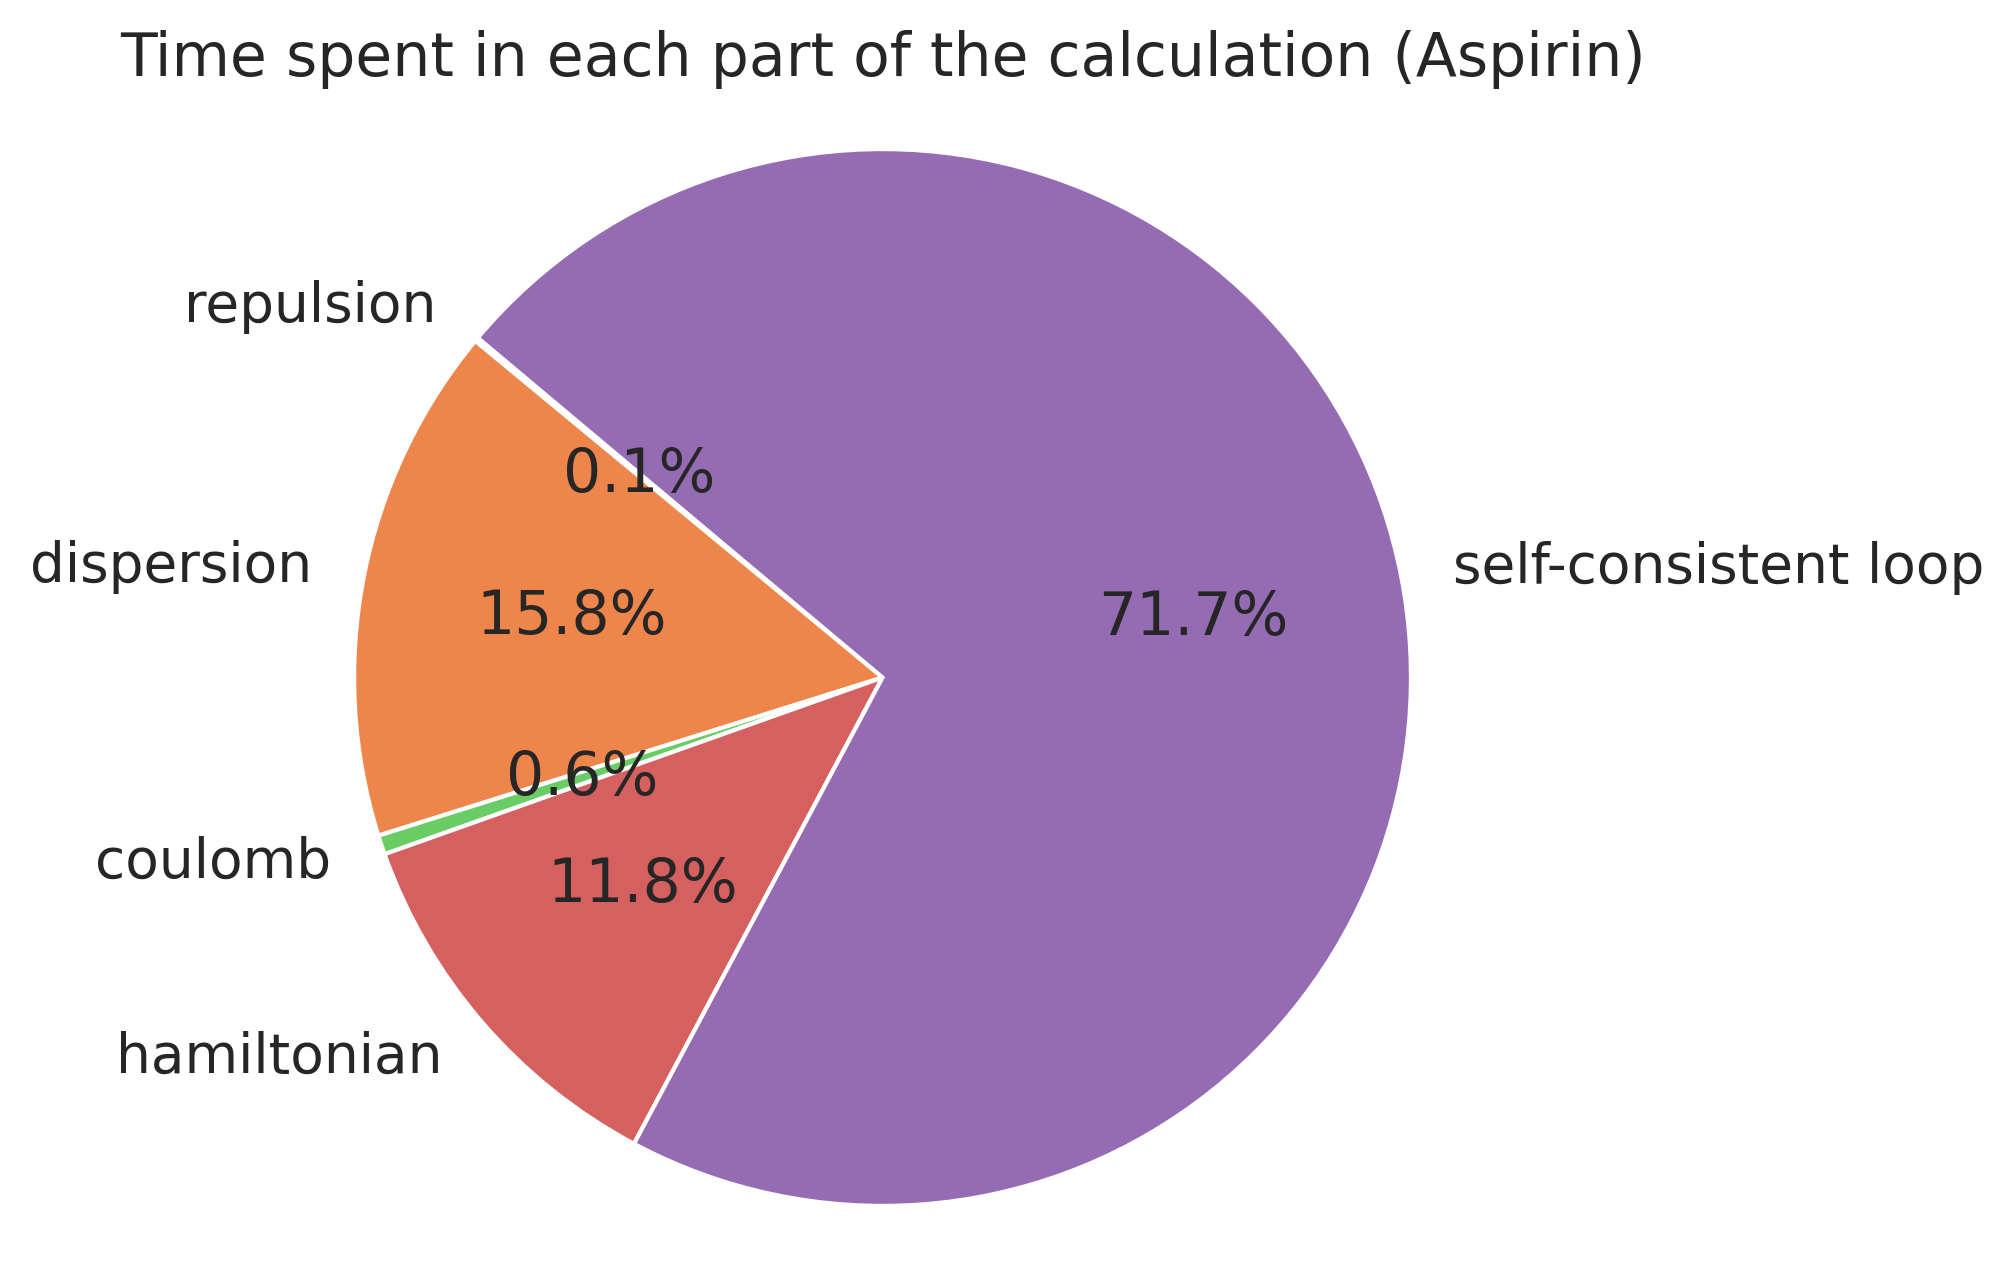

<Figure size 640x480 with 0 Axes>

In [61]:
#  total:                                    0.04176876 sec
#  - repulsion                               0.00004974 sec (                                  0%)
#  - dispersion                              0.00659769 sec (                                 15%)
#  - coulomb                                 0.00024547 sec (                                  0%)
#  - hamiltonian                             0.00490927 sec (                                 11%)
#  - scc                                     0.02987670 sec (                                 71%)

times = {
  "repulsion": 0.00004974,
  "dispersion": 0.00659769,
  "coulomb": 0.00024547,
  "hamiltonian": 0.00490927,
  "self-consistent loop": 0.02987670,
}

# Pie chart on time spent in each part of the calculation, with annotations

sns.set_style("whitegrid")
plt.figure(figsize=(5,5), dpi=300)
plt.pie(times.values(), labels=times.keys(), autopct='%1.1f%%', startangle=140, colors=sns.color_palette("muted", n_colors=len(times)))
plt.title('Time spent in each part of the calculation (Aspirin)')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()
# Save the figure
plt.savefig('notes/figures/performance_pie.png', dpi=300, bbox_inches='tight')

In [ ]:
# Compare performance of rtx4060 with rtx4090 on alkanes (bar plot)

array([0.03440082])

<Figure size 1500x1500 with 0 Axes>

In [3]:
# total shared memory used

# s3d, d3d and q3d
print(
  3 * 8 
  + (5 * 5 * (1 + 3 + 6)) * 8
  # + (3 * 3 * (1 + 3 + 6)) * 8
  # + (1 * 1 * (1 + 3 + 6)) * 8
    +  (6 * 6 * (1 + 3 + 6)) * 8
    # +  (3 * 3 * (1 + 3 + 6)) * 8
    # +  (1 * 1 * (1 + 3 + 6)) * 8
    + (12 * 4 * 8)
)
print(1 * 1 * (1 + 3 + 6) * 8 )

# ialpha, jalpha, icoeff, jcoeff
print(12 * 4 * 8)

# vec[3]
print(3 * 8)

# stmp, dtmpj, qtmpj
print(5 * 5 * (1 + 3 + 6) * 8)

total = 6 * 6 * (1 + 3 + 6) * 8 + 12 * 4 * 8 + 3 * 8 + 5 * 5 * (1 + 3 + 6) * 8
print(f'Total shared memory used: {total} bytes')

5288
80
384
24
2000
Total shared memory used: 5288 bytes
